#   **Advanced Lane Finding Project**

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.image as mpimg
%matplotlib inline
from pprint import pprint
import glob

# Calibrating camera

Assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, objp is just a replicated array of coordinates, and objpoints will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. imgpoints will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. I applied this distortion correction to the test image using the cv2.undistort() function and obtained this result:

In [2]:
def calibrate_camera(images_path,nx=9,ny=6):
    objpoints=[]
    imgpoints=[]
    objp=np.zeros((ny*nx,3),np.float32)
    objp[:,:2]=np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    for image in images_path:
        img=mpimg.imread(image)
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret,corners=cv2.findChessboardCorners(gray,(nx,ny),None)
        if ret==True:
            imgpoints.append(corners)
            objpoints.append(objp)
    return imgpoints,objpoints

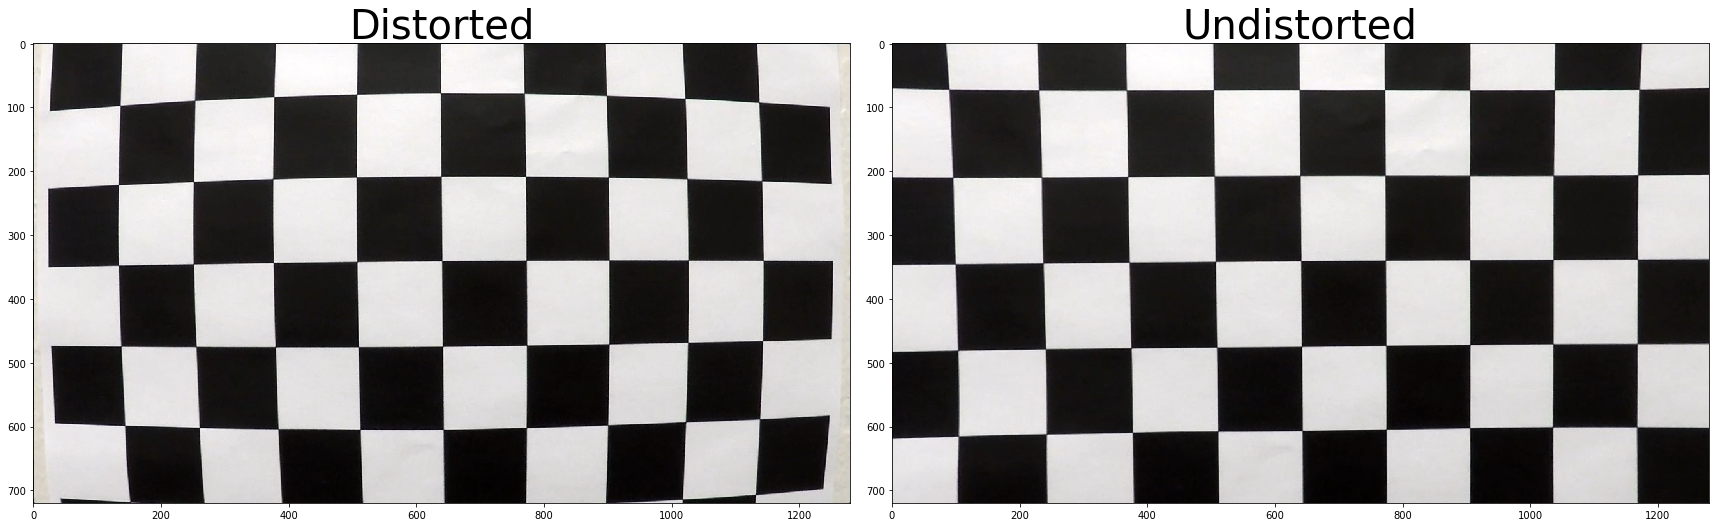

In [3]:
#Calibrate 
images_path=glob.glob('camera_cal/calibration*.jpg')
imgpoints,objpoints=calibrate_camera(images_path)
img=mpimg.imread(images_path[0])
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
test_image = cv2.undistort(img, mtx, dist, None, mtx) 
f, [ax1, ax2] = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img,cmap='gray')
ax1.set_title('Distorted', fontsize=40)
ax2.imshow(test_image,cmap='gray')
ax2.set_title('Undistorted', fontsize=40)


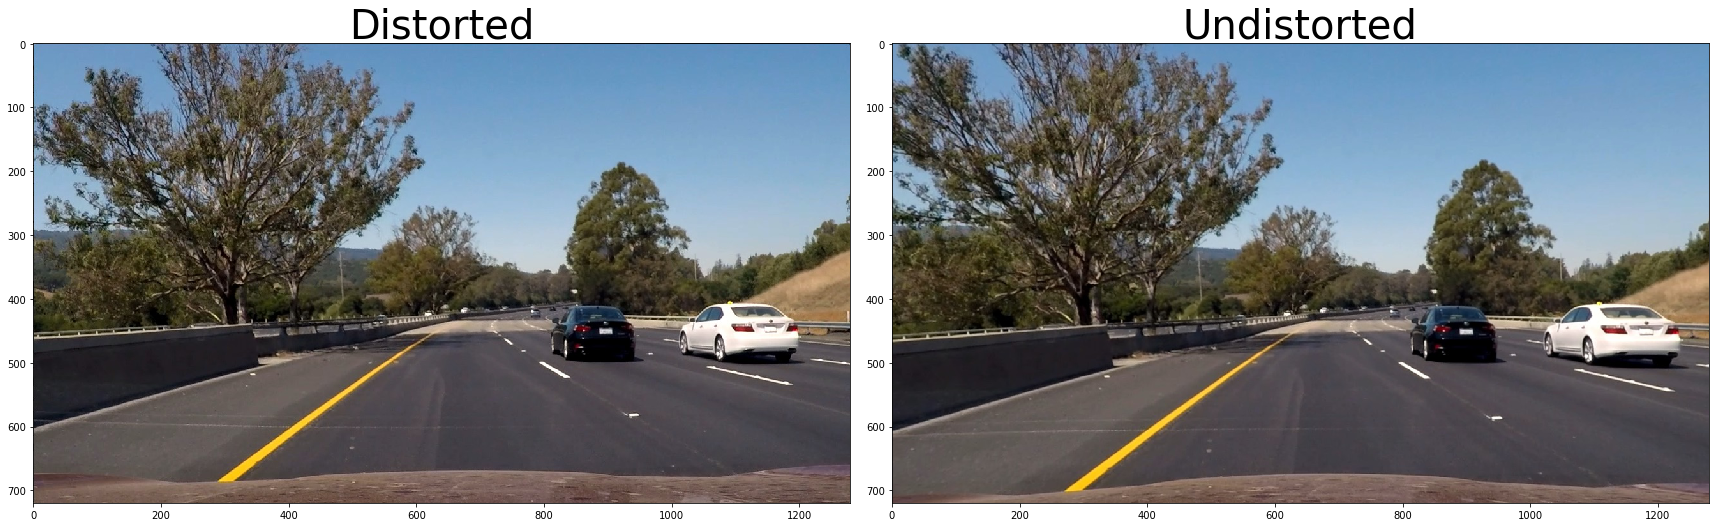

In [4]:
#Undistort image
orig_img=mpimg.imread('test_images/test6.jpg')
test_image = cv2.undistort(orig_img, mtx, dist, None, mtx) 
f, [ax1, ax2] = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(orig_img,cmap='gray')
ax1.set_title('Distorted', fontsize=40)
ax2.imshow(test_image,cmap='gray')
ax2.set_title('Undistorted', fontsize=40)

## How I used color transforms, gradients or other methods to create a thresholded binary image

In the combined_threshold() method I calculated magnitude of gradient threshold and directon threshold and combined them to form one binary image.Then I called binary_saturation() function in which I took converted image into HLS and then extracted the saturation channel froom HLS image. I applied threshold to it such that binary image was created. Then I combined both the binary image returned from the above function. The final image can be shown below.

In [5]:
def combined_threshold(test_image):
    ksize=3
    gradx = abs_sobel_thresh(test_image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(test_image, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    mag_binary = mag_thresh(test_image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(test_image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

def abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def binary_saturation(image,thresh=(90,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    s_binary = np.zeros_like(S)
    s_binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return s_binary


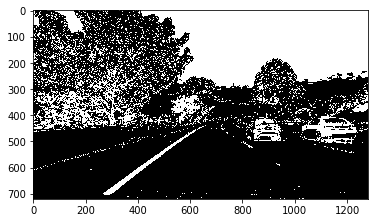

In [6]:

combined_img=combined_threshold(test_image)
sat_img=binary_saturation(test_image)
combined_binary = np.zeros_like(combined_img)
combined_binary[(combined_img == 1) | (sat_img == 1)] = 1
plt.imshow(combined_binary,cmap='gray')

## How I performed a perspective transform

I choose src points which comfortably could fit into the lanes.Then I choose dst points which forms a rectangle.Then I called getperspective() function which takes image,src,dst points and returns the warped image. I verified that my perspective transform was working as expected by drawing the src and dst points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

In [7]:

def getperspective(img,src,dst):
    img_size=(img.shape[1],img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

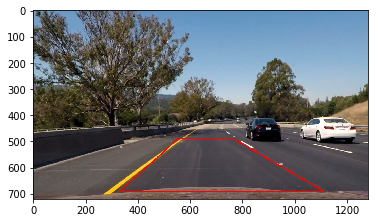

In [8]:

src = np.float32([[570,480],[770,480],[1100,690],[290,690]])
dst = np.float32([[250,0], [1090,0],[1090,700],[250,700]])
pts = np.array([[554,490],[765,490],[1110,690],[330,690]], np.int32)
pts = pts.reshape((-1,1,2))
img_copy = test_image.copy()
cv2.polylines(img_copy,[pts],True,(255,0,0), thickness=3)
plt.imshow(img_copy)

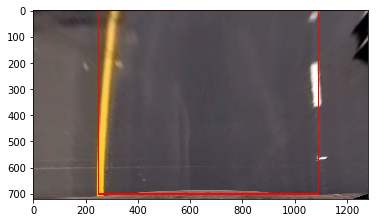

In [9]:
p_image=getperspective(test_image,src,dst)
pts = np.array([[250,0], [1090,0],[1090,700],[250,700]])
pts = pts.reshape((-1,1,2))
img_copy = p_image.copy()
cv2.polylines(img_copy,[pts],True,(255,0,0), thickness=3)
plt.imshow(img_copy)


###  Below is the warped image for binary image

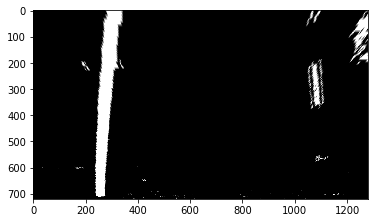

In [10]:

binary_warped=getperspective(combined_binary,src,dst)
plt.imshow(binary_warped,cmap='gray')


## Below histogram shows the values of white pixels in the warped image

Here I took the sum along columns for the warped image to get the position of the peaks. 

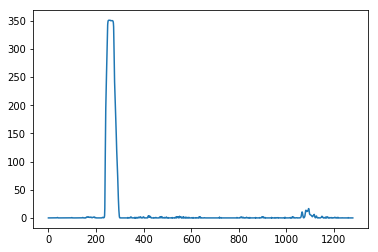

In [11]:
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)

# Finding lane lines

I succesfully identified lane-line pixels and fit their positions with a polynomial.To find lane lines I passed the binary warped image  to the function findlines().In this function I first found out peak of the left and right halves of the histogram. Then I intialized number of sliding windows to 9. I set set height of windows.I Identified the x and y positions of all nonzero pixels in the image and set width margin and minimum number of pixels.After stepping through each window size and getting the desired coordinates of the line. I fitted a second order polynomial to both the lines which are one left and right lane.

In [12]:
def findlines(binary_warped): 
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img,left_fitx,right_fitx,left_fit,right_fit,ploty

def search_area(binary_warped,left_fitx,right_fitx,left_fit,right_fit):   
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
#     print(leftx.shape)
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return result

def curvature_plot(left_fitx,right_fitx,ploty):  
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    mark_size = 3
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.plot(left_fitx, ploty, color='green', linewidth=3)
    plt.plot(right_fitx, ploty, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images


(720, 0)

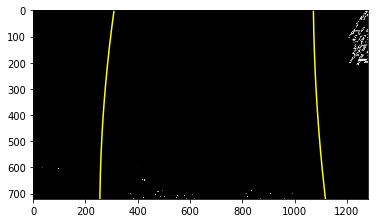

In [13]:
out_img,left_fitx,right_fitx,left_fit,right_fit,ploty=findlines(binary_warped)
result=search_area(binary_warped,left_fitx,right_fitx,left_fit,right_fit)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Calculating the radius of curvature

Radius of curvature can be calculated by calling the function measure_cur_pix() and passing all the arguments to it. As we know the x and y coordinates we can pass get the cofficients of the lines formed by these coordinates using polyfit function.Then using the formula mentioned in the below code we get radius of curvature


In [14]:
def measure_cur_pix(left_fit,right_fit,ploty,left_fitx,right_fitx): 
    y_eval = np.max(ploty)
#     left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
#     right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

In [15]:
left_curverad, right_curverad=measure_cur_pix(left_fit,right_fit,ploty,left_fitx,right_fitx)
print(left_curverad,right_curverad)

1844.9072543379666 2289.646307375599


# Position of the vehicle with respect to center

Below is the code to calculate center offset of the vehicle. For this I took the last element from array of right_fitx & left_fitx which contains the coordinates of the left and right lane and took mean of it .Then gives the center value. I calculated the offset by subtracting the half of length of image.

In [16]:
number_rows = binary_warped.shape[0]
lane_center = (right_fitx[number_rows-1] + left_fitx[number_rows-1])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
center_offset_pixels = abs(640 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
offset_string = "Center offset: %.2f m" % center_offset_mtrs

# Plotting of lane area

To plot lane area I called function draw_lane() which takes the inverse perspective transform and transforms the image into the normal form.

In [17]:
def draw_lane(test_image,binary_warped,left_fitx,right_fitx,ploty,Minv):

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (test_image.shape[1], test_image.shape[0])) 
    # Combine the result with the original image
    result1 = cv2.addWeighted(test_image, 1, newwarp, 0.3, 0)
    return result1



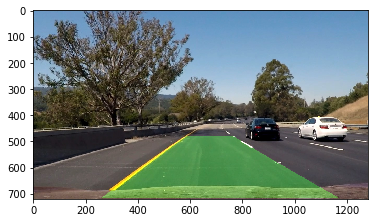

In [18]:
Minv = cv2.getPerspectiveTransform(dst, src)
final_img=draw_lane(orig_img,binary_warped,left_fitx,right_fitx,ploty,Minv)
plt.imshow(final_img)

# Below is my pipeline 

In [ ]:
right_lane_x=None

def mypipeline(orig_img):
    global right_lane_x
    #undistort the image 
    test_image = cv2.undistort(orig_img, mtx, dist, None, mtx) 
    
    #function returns binary image with the combination of gradient,mag,direction threshold
    combined_img=combined_threshold(test_image)
    
    #returns  binary image with certain threshold for staurated image
    sat_img=binary_saturation(test_image)
    
    #combination of gradient threshold and saturation threshold
    combined_binary = np.zeros_like(combined_img)
    combined_binary[(combined_img == 1) | (sat_img == 1)] = 1
    
    #source and destination points for perspective transform
    
    src = np.float32([[570,480],[770,480],[1100,690],[290,690]])
    dst = np.float32([[250,100], [1090,100],[1090,650],[250,650]])
    
    #function returns perspective transform of image
    binary_warped=getperspective(combined_binary,src,dst)
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    #get parameter for inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #find lane lines for binary warped image
    out_img,left_fitx,right_fitx,left_fit,right_fit,ploty=findlines(binary_warped)
    
    #getting previous averaqe frame if right cordinates are displaced for that particular frame
    if(np.min(right_fitx)<950 or np.max(right_fitx)<1060):
        if(right_lane_x is not None):
            right_fitx=right_lane_x
    else:
        if(right_lane_x is not None):
            right_lane_x=(3*right_fitx+right_lane_x)/4
        else:
            right_lane_x=right_fitx
    
    result=search_area(binary_warped,left_fitx,right_fitx,left_fit,right_fit)
    
    #getting radius of curvature
    left_curverad, right_curverad=measure_cur_pix(left_fit,right_fit,ploty,left_fitx,right_fitx)
    
    #draw green lane on road
    final_img=draw_lane(orig_img,binary_warped,left_fitx,right_fitx,ploty,Minv)
    
    #offsets for putting small images on the image
    x_offset=y_offset=50
    x_offset1=270
    y_offset1=50
    x_offset3=920
    x_offset2=600
    y_offset2=50
    
    f = plt.figure()
    ax = plt.subplot(111)
    ax.plot(histogram)
    
    bw = np.dstack((binary_warped, binary_warped, binary_warped))*255
    cb = np.dstack((combined_binary, combined_binary, combined_binary))*255
    
    bws=cv2.resize(bw, (300, 200))
    result=cv2.resize(result, (300, 200))
    cb=cv2.resize(cb, (300, 300))
    
    f.savefig('plot1.jpg')
    img_bgr=mpimg.imread("plot1.jpg")
    hist_img=cv2.resize(img_bgr, (200, 200))
    
    #finding center offset
    number_rows = binary_warped.shape[0]
    lane_center = (right_fitx[number_rows-1] + left_fitx[number_rows-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(640 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    
    #putting different images on big image
    final_img[y_offset:y_offset+hist_img.shape[0], x_offset:x_offset+hist_img.shape[1]] = hist_img
    final_img[y_offset:y_offset+cb.shape[0], x_offset3:x_offset3+cb.shape[1]] = cb
    final_img[y_offset1:y_offset1+bws.shape[0], x_offset1:x_offset1+bws.shape[1]] = bws
    final_img[y_offset2:y_offset2+result.shape[0], x_offset2:x_offset2+result.shape[1]] = result
    
    #put radius of curvature and offset on the image
    cv2.putText(final_img,"ROC:"+str((left_curverad+right_curverad)/2), (50,290), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),thickness=2)
    cv2.putText(final_img, offset_string, (50, 320), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)
    
    return final_img

# testing=mpimg.imread("test_images/test1.jpg")
# plt.imshow(mypipeline(testing))
# plt.show()

In [ ]:
import os

from moviepy.video.VideoClip import VideoClip
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'project_video_final.mp4'
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(37,42)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(mypipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# Discussion

**While working on the project I faced issue to make perspective transform perfect. I had to try with different destination points to get the right perspective transform.
Another issue I faced was to get right values of threshold for magnitute and direction gradient threshold.** 

**This pipeline is not able to work for the challenge video and harder challenge video.The challenge video contains white edges towards the left lane so the lane region goes till the edge of the road which should not happen. Dynamic warpping of image may work better.Much more experimentation with the color spaces can make my pipeline more robust.**